<a href="https://colab.research.google.com/github/lyk6666/SC3000/blob/main/SC3000_Assignment1_SCSX_LiYikai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SC3000_Assignment1_SCSX_LiYikai

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 58.2 MB/s eta 0:00:00


## Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

In [ ]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Tutorial: Loading CartPole environment

In [ ]:
env = gym.make("CartPole-v1")

## Task 1: Development of an RL agent

First, we need to generate a **Well-defined Problem Formulation** for better prototyping and solving:
* **Definition of the problem**:
 * Develop a Reinforcement Learning (RL) agent to balance a pole on a cart by applying forces to move left or right. The agent should maximize the time the pole remains upright.
* **Formulation:**
 * **Initial state**: The cart starts at a random position, with the pole at a small random angle and small random velocities.
 * **Action set**: 	The agent can take one of two actions: move the cart left (0) or right (1).
 * **State space**: The environment has continuous state variables:
    1. Cart Position (-4.8 to 4.8)
    2. Cart Velocity (unbounded)
    3. Pole Angle (~ -0.418 rad to 0.418 rad)
    4. Pole Angular Velocity (unbounded)
 * **Solution path**: A sequence of actions (left/right) that maintain pole balance over time.
 * **Goal Predicate**: The episode continues until one of the following happens:
    1. ✅ Success: The agent balances the pole for a long duration.
    2. ❌ Failure: The pole angle exceeds ±12° OR the cart moves beyond ±2.4 position.
 * **Cost Function**:
 	The RL agent receives a reward of +1 per time step. The goal is to maximize cumulative rewards (i.e., keep the pole balanced as long as possible).

**Types of environment**:

---
1.  **Accessible**✅ → The agent gets full state information, which is cart’s position, velocity, pole angle, and angular velocity respectively.
---
2.  **Deterministic**✅ → The physics equations determine state transitions.
---
3.  **Episodic**✅ → The agent’s past episodes do not affect new ones. Each episode starts fresh, without any memory of the previous episode.
---
4.  **Static**✅ → The environment does not change unless the agent interacts.
---
5.  **Discrete Actions**✅ → The agent can only move left (0) or right (1).
---

### Step 1: Define the Deep Q-Network model

* Traditional Q-learning maintains a Q-table (state-action value table), but in this question, CartPole has a continuous space state, where tabular representation is insufficient.

* Therefore, we are going to use Deep Q-Network (DQN), which uses a deep neural network to approximate the Q-values given a state.

Since the sample code import ***tensorflow***, we will utilize functions from ***tensorflow*** to construct the Deep Q-Network agent.

In [ ]:
def build_dqn():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(24, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(2, activation='linear')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
  return model

dqn_model = build_dqn()
dqn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 24)                  │             120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              50 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 770 (3.01 KB)

 Trainable params: 770 (3.01 KB)

 Non-trainable params: 0 (0.00 B)

The model is created using ***tf.keras.models.Sequential***. A sequential model means that the layers are stacked in order, where the output of one layer becomes the input of the next.

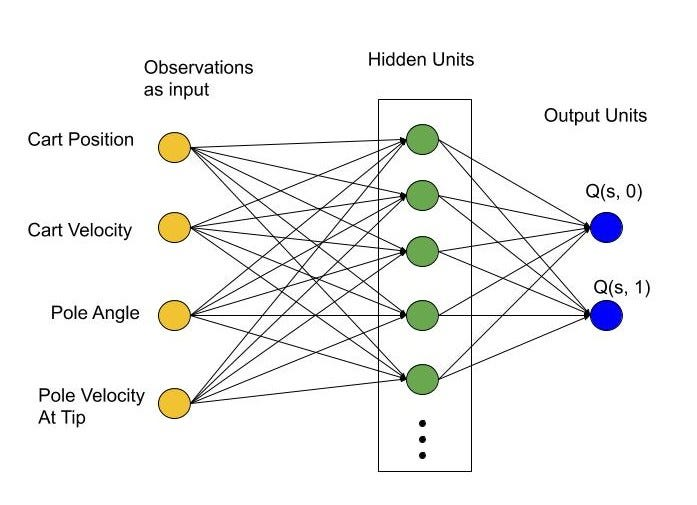

* **First Dense Layer**:
```python
tf.keras.layers.Dense(24, activation='relu', input_shape=(4,))
```

 * 24 neurons.
 * ReLU (Rectified Linear Unit) activation function (Computationally cheaper than **Sigmoid** and **Tanh**).
 * Input shape: (4,), meaning the model expects an input vector of size 4.
 * (4 inputs * 24 neurons) + 24 biases = 120 parameters.

* **Second Dense Layer**:
```python
tf.keras.layers.Dense(24, activation='relu'),
```

 * 24 neurons.
 * ReLU (Rectified Linear Unit) activation function.
 * Input shape: (4,), meaning the model expects an input vector of size 4.
 * (24 inputs * 24 neurons) + 24 biases = 600 parameters.

* **Output Layer**:
```python
tf.keras.layers.Dense(2, activation='linear')
```

 * 2 neurons (representing 2 possible actions in the environment).
 * Linear activation, meaning it outputs raw Q-values for each action.
 * (24 inputs * 2 neurons) + 2 biases = 50 parameters.

**Loss Computation**: We use ***Mean Squared Error (MSE)*** as the loss function, which is indicated in:
```python
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
```

**Backpropagation**: The loss is minimized using **gradient descent** (Adam optimizer in this case), updating the model’s weights.

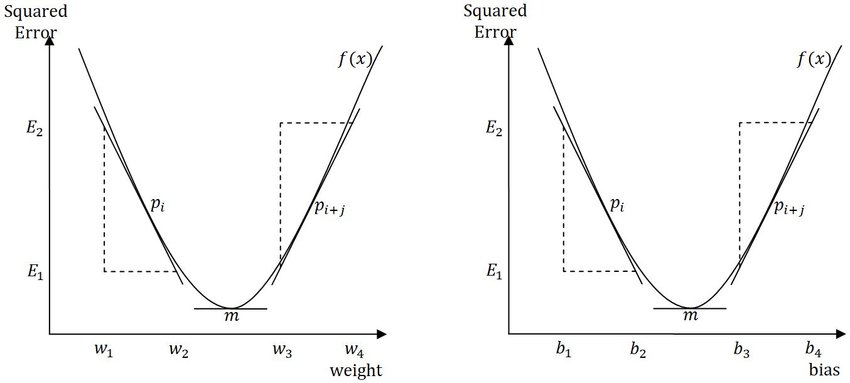
* If the predicted Q-value is too high, the gradient is positive, and the weight decreases.
* If the predicted Q-value is too low, the gradient is negative, and the weight increases.

Adam is an optimization algorithm that combines the strengths of:
1. **Momentum-based** optimization (like SGD with momentum)
2. **Adaptive learning rate** methods (like RMSprop)

Why learning rate equals to 0.001 in *tf.keras.optimizers.Adam(learning_rate=0.001)*?
* Too high (e.g., 0.01) → Q-values diverge, training becomes unstable.
* Too low (e.g., 0.0001) → Convergence is too slow.

Finally, the function returns the compiled DQN model.


### Step 2: Implement Experience Relay Memory


In [ ]:
from collections import deque

class ReplayBuffer:
  def __init__(self, capacity=20000):
    self.buffer = deque(maxlen=capacity)

  def store(self, experience):
    self.buffer.append(experience)

  def sample(self, batch_size):
    return random.sample(self.buffer, batch_size)

  def size(self):
    return len(self.buffer)

This code defines a **ReplayBuffer** class, which is a key component in Deep Q-Networks (DQN). The replay buffer is used to store and sample experiences for training the agent.

```python
  def __init__(self, capacity=20000):
    self.buffer = deque(maxlen=capacity)
```

* ***self.buffer***: A list that will store the experiences.

* ***capacity***: The maximum size of the buffer.

Why use *deque* instead of *list*?

- deque is optimized for appending/removing from both ends, unlike a normal list where pop(0) shifts all elements, making it slow.

```python
  def store(self, experience):
    self.buffer.append(experience)
```

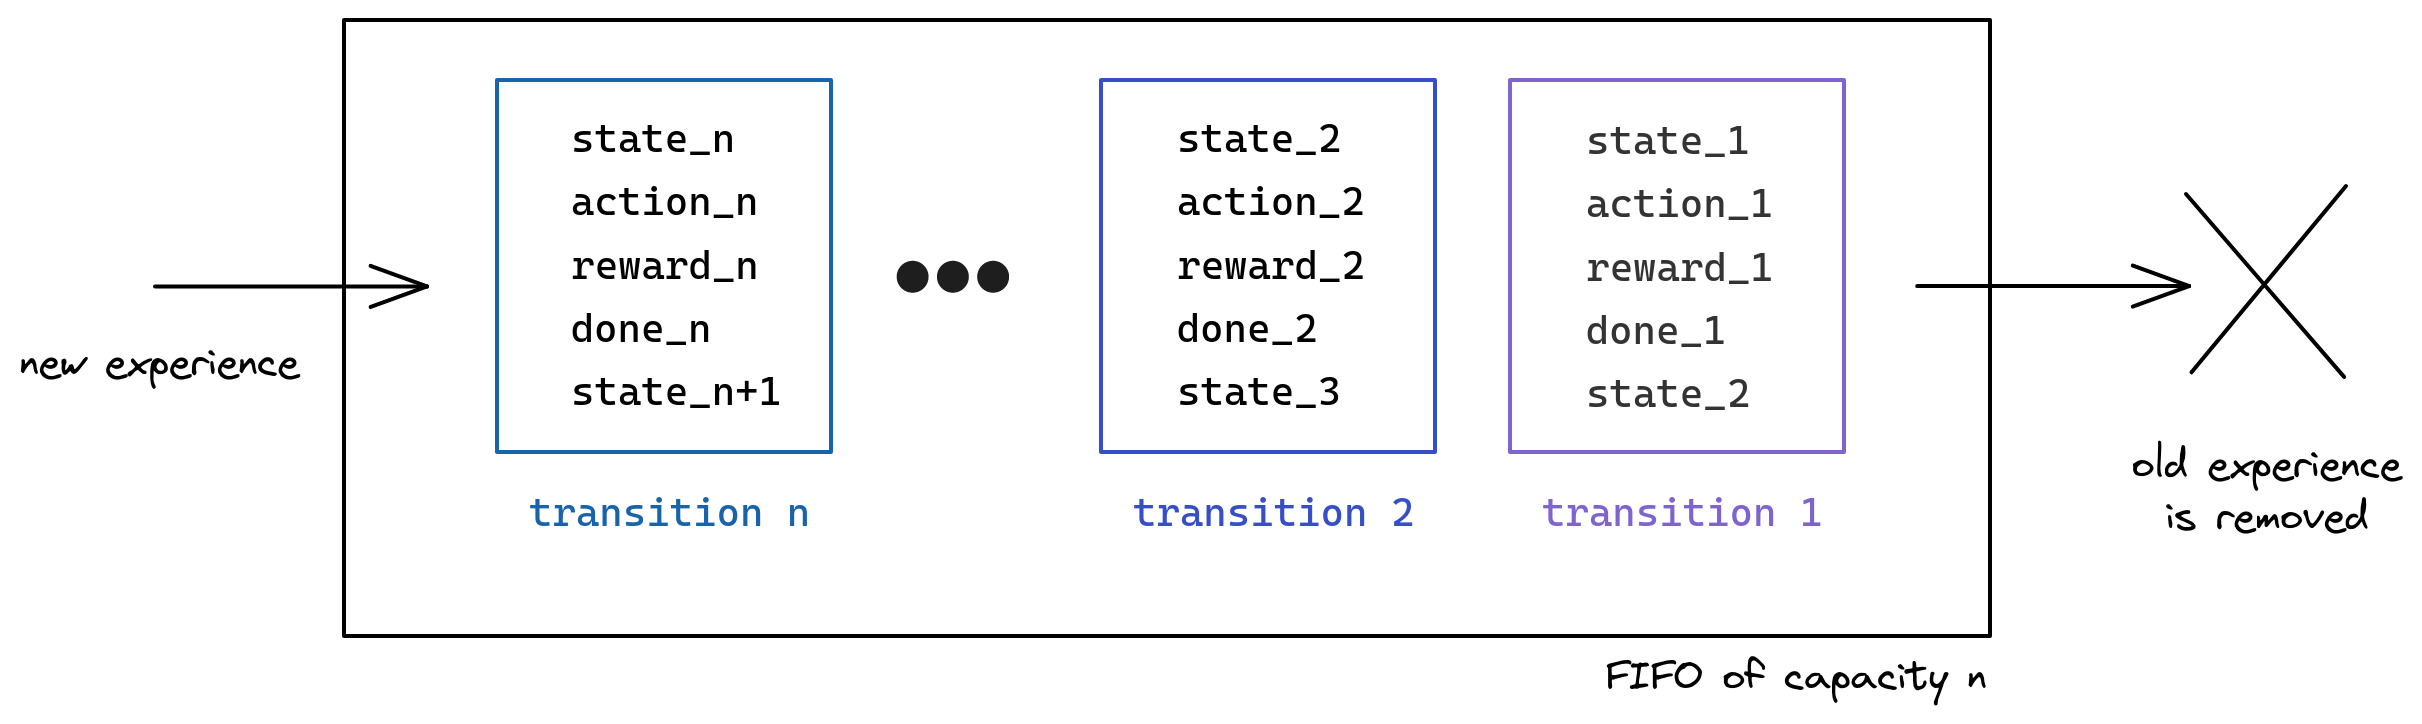

* ***experience***: A tuple or object representing an experience, typically in the form (state, action, reward, next_state, done).

* If the buffer is full, then the oldest experience in the end is removed in the deque. The new experience is appended to the end of the buffer using append(experience).

* **Purpose**: Ensures the buffer does not exceed its capacity by removing old experiences when necessary.


```python
  def sample(self, batch_size):
    return random.sample(self.buffer, batch_size)
```

* ***batch_size***: The number of experiences to sample.

* Uses Python's *random.sample* function to randomly select *batch_size* experiences from the buffer.

* **Purpose**: Random sampling helps break the correlation between consecutive experiences, improving the stability of training in reinforcement learning.



### Step 3: Define the DQN Training Algorithm

In [ ]:
class DQNAgent:
  def __init__(self):
    self.model = build_dqn()
    self.target_model = build_dqn()
    self.update_target_model()

    self.memory = ReplayBuffer()
    self.gamma = 0.99
    self.epsilon = 1.0
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.batch_size = 32
    self.train_start = 1000

  def update_target_model(self):
    self.target_model.set_weights(self.model.get_weights())

  def select_action(self, state):
    if np.random.rand() <= self.epsilon:
      return np.random.choice([0, 1])
    q_values = self.model.predict(state.reshape(1, -1), verbose=0)
    return np.argmax(q_values[0])


  def train(self):
    if self.memory.size() < self.train_start:
      return

    batch = self.memory.sample(self.batch_size)

    states = np.array([experience[0] for experience in batch], dtype=np.float32)

    actions = np.array([experience[1] for experience in batch], dtype=np.int32)
    rewards = np.array([experience[2] for experience in batch], dtype=np.float32)
    next_states = np.array([experience[3] for experience in batch], dtype=np.float32)
    dones = np.array([experience[4] for experience in batch], dtype=np.bool_)

    q_values = self.model.predict(states, verbose=0)
    next_q_values = self.target_model.predict(next_states, verbose=0)

    for i in range(self.batch_size):
      target = rewards[i]
      if not dones[i]:
        target += self.gamma * np.max(next_q_values[i])
      q_values[i][actions[i]] = target

    self.model.fit(states, q_values, epochs=1, verbose=0, batch_size=self.batch_size)

    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay

agent = DQNAgent()

This code defines a DQNAgent class, which implement DQN agent for machine learning.

```python
  def __init__(self):
    self.model = build_dqn()
    self.target_model = build_dqn()
    self.update_target_model()
    self.memory = ReplayBuffer()
    self.gamma = 0.99
    self.epsilon = 1.0
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.batch_size = 32
    self.train_start = 1000
```

* Neural Networks:

 * ***self.model***: The main DQN model used for action selection and training.

 * ***self.target_model***: A target model used to compute target Q-values during training.

 * ***self.update_target_model()***: Initializes the target model with the weights of the main model.

* Replay Buffer:

 * ***self.memory***: An instance of the ReplayBuffer class to store experiences.

* Hyperparameter:

 * ***self.gamma***: The discount factor (default: 0.99), which determines the importance of future rewards.

 * ***self.epsilon***: The exploration rate (default: 1.0), which controls the probability of taking a random action.

 * ***self.epsilon_min***: The minimum value of epsilon (default: 0.01), ensuring some exploration even after decay.

 * ***self.epsilon_decay***: The decay rate for epsilon (default: 0.995), reducing exploration over time.

 * ***self.batch_size***: The number of experiences sampled from the replay buffer for training (default: 32).

 * ***self.train_start***: The number of experiences required in the replay buffer before training starts (default: 1000).

```python
  def update_target_model(self):
    self.target_model.set_weights(self.model.get_weights())
```

* This method updates the target model's weights to match the main model's weights.

* The target model is used to compute stable Q-values during training, and updating it periodically helps improve training stability.

```python
  def select_action(self, state):
    if np.random.rand() <= self.epsilon:
      return np.random.choice([0, 1])
    q_values = self.model.predict(state.reshape(1, -1), verbose=0)
    return np.argmax(q_values[0])
```

* This method selects an action for the agent to take in a given state.

* ***state***: The current state of the environment.

* Logic:

 * **Exploration**: With probability self.epsilon, the agent takes a random action *(np.random.choice([0, 1]))*.

 * **Exploitation**: Otherwise, the agent uses the main model to predict Q-values for the state and selects the action with the highest Q-value *(np.argmax(q_values[0]))*.


```python
  def train(self):
```

* This method trains the agent using experiences sampled from the replay buffer.

Steps:

1. **Check Buffer Size**: If the replay buffer has fewer experiences than self.train_start, training is skipped.

> ```python
    if self.memory.size() < self.train_start:
      return

2. **Sample Batch**: A batch of experiences is sampled from the replay buffer.

> ```python
    batch = self.memory.sample(self.batch_size)

3. **Extract Data**: The batch is split into states, actions, rewards, next_states, and dones.

> ```python
    actions = np.array([experience[1] for experience in batch], dtype=np.int32)
    rewards = np.array([experience[2] for experience in batch], dtype=np.float32)
    next_states = np.array([experience[3] for experience in batch], dtype=np.float32)
    dones = np.array([experience[4] for experience in batch], dtype=np.bool_)

4. **Predict Q-Values**:

>```python
    q_values = self.model.predict(states, verbose=0)
    next_q_values = self.target_model.predict(next_states, verbose=0)

 * The main model predicts Q-values for the current states.

 * The target model predicts Q-values for the next states.

5. **Compute Targets**:

>```python
    for i in range(self.batch_size):
      target = rewards[i]
      if not dones[i]:
        target += self.gamma * np.max(next_q_values[i])
      q_values[i][actions[i]] = target

* For each experience in the batch:

 * If the episode is not done (not dones[i]), the target Q-value is computed as: ***target = rewards[i] + self.gamma * np.max(next_q_values[i])***, which is the implementation of Bellman Equation.
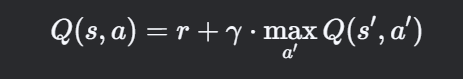

   * **q_value** -> The predicted Q-values for the current state s and all possible actions a.

   * **next_q_value** -> The predicted Q-values for the next state s′ and all possible actions a′.

 * If the episode is done, the target is just the reward.

* The target Q-value is assigned to the corresponding action in q_values.

6. **Train the Model**: The main model is trained on the batch of states and updated Q-values.

>```python
    self.model.fit(states, q_values, epochs=1, verbose=0, batch_size=self.batch_size)
* epochs is the number of times the model will iterate over the entire dataset

7. **Decay Epsilon**: The exploration rate epsilon is decayed by multiplying it with self.epsilon_decay, ensuring gradual reduction in exploration.

>```python
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay


### Step 4: Train the DQN Agent

* We decided to take **200 episodes** for model training. Each episode represent a complete interaction between the agent and the environment, from the initial state to a terminal state.

* Every 10 episodes the target model is updated to match the main model.

Explanation of training loop:
1. Reset the environment and initialize the *total_reward* to 0 and done to false

2. Take an action chosen by function *select_action(state)*, observe the next_state, reward and done, and store them into replay buffer

3. Sample a batch of experiences from the replay buffer and compute target Q-values using the target model. Then train the main model on the batch.

4. Accumulate the reward for the episode and update the current state to next_state.

5. Record the total reward for the episode and periodically update the target model.

6. Print the episode number, total reward, and current epsilon.

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1, Total Reward: 12.0, Epsilon: 1.000
Episode 2, Total Reward: 24.0, Epsilon: 1.000
Episode 3, Total Reward: 52.0, Epsilon: 1.000
Episode 4, Total Reward: 14.0, Epsilon: 1.000
Episode 5, Total Reward: 39.0, Epsilon: 1.000
Episode 6, Total Reward: 21.0, Epsilon: 1.000
Episode 7, Total Reward: 11.0, Epsilon: 1.000
Episode 8, Total Reward: 13.0, Epsilon: 1.000
Episode 9, Total Reward: 22.0, Epsilon: 1.000
Episode 10, Total Reward: 14.0, Epsilon: 1.000
Episode 11, Total Reward: 40.0, Epsilon: 1.000
Episode 12, Total Reward: 23.0, Epsilon: 1.000
Episode 13, Total Reward: 23.0, Epsilon: 1.000
Episode 14, Total Reward: 22.0, Epsilon: 1.000
Episode 15, Total Reward: 27.0, Epsilon: 1.000
Episode 16, Total Reward: 9.0, Epsilon: 1.000
Episode 17, Total Reward: 17.0, Epsilon: 1.000
Episode 18, Total Reward: 10.0, Epsilon: 1.000
Episode 19, Total Reward: 13.0, Epsilon: 1.000
Episode 20, Total Reward: 30.0, Epsilon: 1.000
Episode 21, Total Reward: 12.0, Epsilon: 1.000
Episode 22, Total Rewar

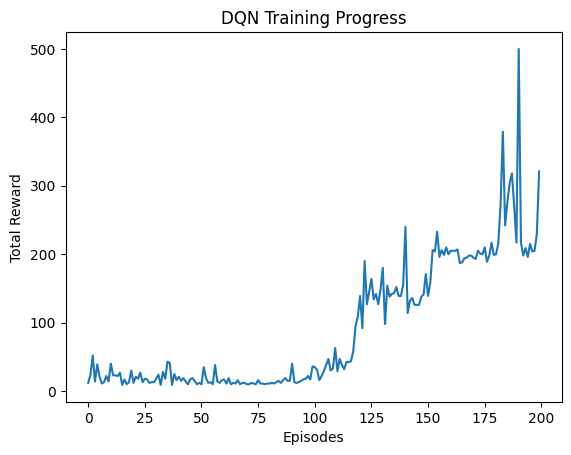

In [ ]:
episodes = 200
update_target_every = 10

reward_history = []

for episode in range(episodes):
  state = env.reset(seed=42)
  total_reward = 0
  done = False

  while not done:
    action = agent.select_action(state)
    next_state, reward, done, _ = env.step(action)

    agent.memory.store((state, action, reward, next_state, done))
    agent.train()

    total_reward += reward
    state = next_state

  reward_history.append(total_reward)

  if episode % update_target_every == 0:
    agent.update_target_model()

  print(f"Episode {episode+1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")

plt.plot(reward_history)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("DQN Training Progress")
plt.show()

Output Analysis:

1. **Exploration Phase**

 * Epsilon: Starts at 1.0 (full exploration) and remains constant until Episode 51.

 * Total Reward: Highly variable, ranging from 9.0 to 52.0.

 The agent is primarily exploring the environment, taking random actions, and the rewards are low and inconsistent, indicating that the agent has not yet learned an effective policy.

2. **Transition Phase**

 * Epsilon: Gradually decays from 0.865 to 0.010.

 * Total Reward: Begins to show slight improvement, with occasional spikes (e.g., 63.0 in Episode 110).

 The agent starts to balance exploration and exploitation, and the rewards are still inconsistent, but occasional higher rewards suggest the agent is beginning to learn.

3. **Exploitation Phase**

 * Epsilon: Stabilizes at 0.010 (minimal exploration).

 * Total Reward: Shows significant improvement, with rewards consistently above 100.0 and occasional spikes (e.g., 500.0 in Episode 191).

 The agent is primarily exploiting its learned policy and the rewards are much higher and more stable, indicating that the agent has learned an effective policy.



## Task 2: Demonstrate the effectiveness of the RL agent

For this task, we use the agent developed in Task 1 to play the game for 100 episodes, record the cumulative reward for each round, and plot the reward for each round.

Below is the code to play for 100 episodes and plot the episode_results for better visualization.

In each episode, we use the code below to select an action without training:

```python
    action = np.argmax(agent.model.predict(state.reshape(1, -1), verbose=0))
```

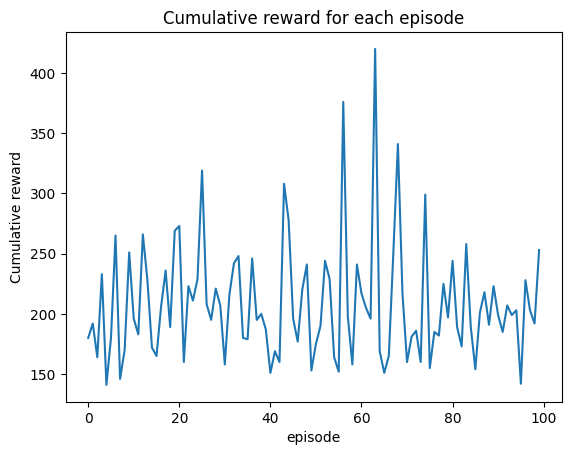

In [ ]:
episode_results = []
for i in range(100):
  state = env.reset()
  done = False
  total_reward = 0

  while not done:
    action = np.argmax(agent.model.predict(state.reshape(1, -1), verbose=0))
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    state = next_state
  episode_results.append(total_reward)

plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [ ]:
mean = sum(episode_results)/len(episode_results)
print("Average cumulative reward:", mean)
print("Is my agent good enough?", mean > 195)

Average cumulative reward: 208.22
Is my agent good enough? True


Result Analysis:

1. **Total Reward Trend**

 1. The cumulative reward per episode fluctuates significantly, indicating varying episode performance.
 2. Despite fluctuations, the reward remains mostly above 150, with peaks exceeding 400 in some episodes.
 3. There is no clear downward trend, which suggests that the agent is not deteriorating but is performing with some variance.

2. **Average Total Reward**

 1. The calculated average reward over 100 episodes is 208.22.
 2. The agent is considered "good enough" if the average reward exceeds 195.
 3. Since 208.22 > 195, the agent meets the required threshold and is considered **successful.**

## Task 3: Render one episode played by the agent

Plug the agent to the code below to obtain rendered result.

In [ ]:
observation = env.reset()
print(observation)

[-0.00303894 -0.03458338 -0.02800035  0.02899676]


In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
total_reward = 0
while True:
    env.render()
    #your agent goes here
    action = np.argmax(agent.model.predict(observation.reshape(1, -1), verbose=0))
    observation, reward, done, info = env.step(action)
    if done:
      break;
    total_reward += 1
print("total rewards: ", total_reward)
env.close()
show_video()

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


total rewards:  204


By utilizing the built-in function ***RecordVideo***, we can have a more straightforward evaluation and assessment on the agent's effectiveness.

We can confidently conclude that our agent works efficiently and successfully.